In [1]:
import joblib
import numpy as np

import mujoco

from hydrax.algs import CEM, MPPI, PredictiveSampling, Evosax, xNES, CMAES, SVES, GaussianSmoothing
from hydrax.simulation.deterministic import run_interactive
from hydrax.tasks.cart_pole import CartPole
from hydrax.tasks.double_cart_pole import DoubleCartPole
from hydrax.tasks.cube import CubeRotation
from hydrax.tasks.walker import Walker
from hydrax.simulation.traj_opt import traj_opt_helper

In [6]:
# task = CartPole()
task = CubeRotation()
mj_model = task.mj_model
mj_model.opt.timestep = 0.01
mj_model.opt.iterations = 5
mj_data = mujoco.MjData(mj_model)

num_trails = 1
max_iterations = 100
num_samples = 1024

In [ ]:

xnes = xNES(
    task,
    num_samples = num_samples,
    temperature= 0.1,
    sigma = 0.3,
    lr_sigma=0.5,
    lr_B = 0.05,
    plan_horizon=1.0,
    spline_type="cubic",
    num_knots=100,
    iterations = 1
)
to = traj_opt_helper(xnes, mj_model, mj_data)
to.trails(max_iteration=max_iterations, num_trails = num_trails)


In [ ]:

cmaes = CMAES(
    task,
    num_samples = num_samples,
    sigma = 0.3,
    plan_horizon=1.0,
    spline_type="cubic",
    num_knots=100,
    iterations = 1
)

to = traj_opt_helper(cmaes, mj_model, mj_data)
to.trails(max_iteration=max_iterations, num_trails = num_trails)


In [ ]:
mppi = MPPI(
    task,
    num_samples = num_samples,
    temperature=0.1,
    noise_level= 0.3,
    plan_horizon=1.0,
    spline_type="cubic",
    num_knots=100,
    iterations = 1
)
mj_model = task.mj_model

to = traj_opt_helper(mppi, mj_model, mj_data)
to.trails(max_iteration=max_iterations, num_trails = num_trails)


In [7]:
gs = GaussianSmoothing(
    task,
    num_samples = num_samples,
    temperature=0.1,
    sigma= 0.3,
    plan_horizon=1.0,
    spline_type="cubic",
    num_knots=100,
    iterations = 1
)
mj_model = task.mj_model

to = traj_opt_helper(gs, mj_model, mj_data)
to.trails(max_iteration=max_iterations, num_trails = num_trails)


strategy:False
Trajectory Optimization with 100 steps over a 1.0 second horizon.
Jitting the controller...


/home/rooh/miniconda3/envs/hydrax/lib/python3.12/site-packages/jax/_src/interpreters/xla.py:119: RuntimeWarning: overflow encountered in cast
  return np.asarray(x, dtypes.canonicalize_dtype(x.dtype))
/home/rooh/miniconda3/envs/hydrax/lib/python3.12/site-packages/jax/_src/interpreters/xla.py:119: RuntimeWarning: overflow encountered in cast
  return np.asarray(x, dtypes.canonicalize_dtype(x.dtype))


Time to jit: 60.246 seconds
path created: data/CubeRotation


100%|██████████| 100/100 [01:19<00:00,  1.25it/s]

Optimization done.
Results saved


In [8]:
task_name = task.__class__.__name__
path = "data/" + task_name + "/"

# xNES_costs = joblib.load(path + "xNES_costs_trails_average.pkl")
# MPPI_costs = joblib.load(path + "MPPI_costs_trails_average.pkl")
# CMAES_costs = joblib.load(path + "CMAES_costs_trails_average.pkl")
GS_costs = joblib.load(path + "GaussianSmoothing_costs_trails_average.pkl")


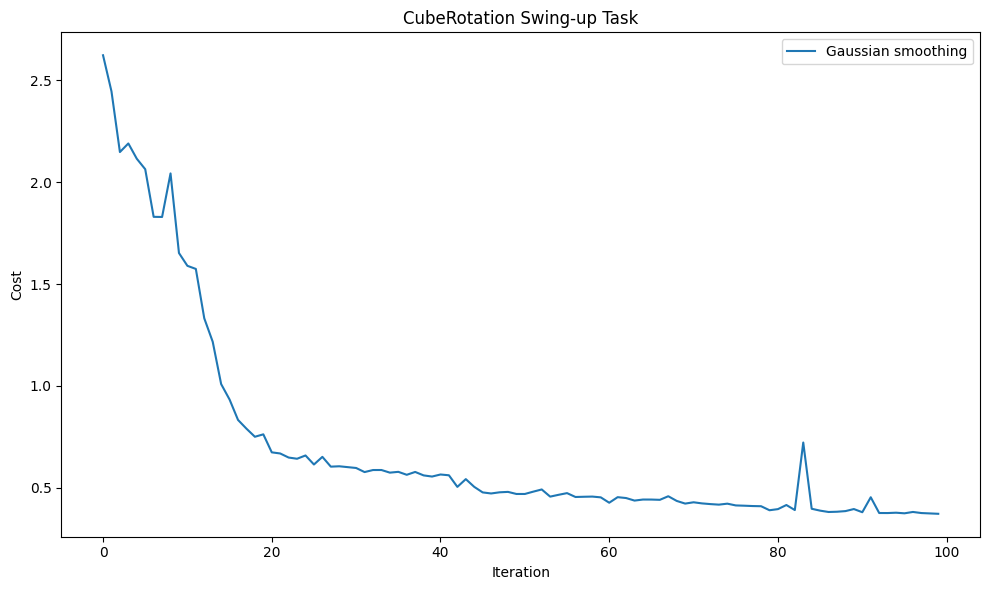

In [ ]:
import matplotlib.pyplot as plt

# print(xNES_costs)
# # Plot the costs
plt.figure(figsize=(10, 6))

# xNES_costs = np.array(xNES_costs).T
# MPPI_costs = np.array(MPPI_costs).T
# CMAES_costs = np.array(CMAES_costs).T
GS_costs = np.array(GS_costs).T


# plt.plot(xNES_costs,   label="xNES")
# plt.plot(MPPI_costs,   label="MPPI")
# plt.plot(CMAES_costs,  label="CMA-ES")
plt.plot(GS_costs,  label="Gaussian smoothing")


plt.title( task_name + "Task")
plt.xlabel("Iteration")
plt.ylabel("Cost")

# single legend call:
plt.legend(loc="best")
plt.tight_layout()
plt.show()
